## License
This file is part of the project megFingerprinting. All of megFingerprinting code is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. megFingerprinting is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with megFingerprinting. If not, see https://www.gnu.org/licenses/.

In [1]:
import difflib
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
import re
import seaborn as sns
import scipy as sp
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
sns.set()
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("husl", 8))

/Users/jasondsc/opt/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# I. Subject Identifiability: Original Feature Space vs PCA Reconstructed

## Select frequency band folder and adjust number of features

In [2]:
# Parameters
n_subs = 47 # Change here to get number of participants! 
nfreq= 34
n_feats = int(68*nfreq) # 201 hgamma   40 gamma  34 beta  10 alpha    8 theta   8 delta  
n_measurements = 2

In [3]:
# Warangle data set into two big feature matrices

# beta -> v == 50 // filename[39:43]

def prune_subject_csv(filename):
    '''
    This function takes in the subject's csv file from MATLAB, takes out the 
    doubled correlations (because of symmetry) and outputs a numpy array ready to be concatenated
    in the grand feature matrix
    Args:
        filename (string): Name of the csv matrix
    Returns: 
        sub_feat (np.array): Subject's features 
    '''
    #print(filename)
    print(filename[39:43])
    n_feats = int(68*nfreq)
    sub_feat = np.zeros([1, (n_feats)+1]) # Number of unique values in corr matrix + subject label
    psd_matrix = pd.read_csv(filename, header=None)
    mat=np.asmatrix(psd_matrix)
    sub_feat[0, :-1]=mat.flatten()
    sub_feat[0, -1] = int(filename[39:43])    
    return sub_feat


# Get n subjects: both training and testing datasets
onlyfiles = [f for f in listdir('output/PSD_SOURCES_twosession/beta/') if isfile(join('output/PSD_SOURCES_twosession/beta/', f))]
sub_target = np.zeros([n_subs, (n_feats)+1])
sub_database = np.zeros([n_subs, (n_feats)+1])
iv = 0
it = 0
for iFile in sorted(onlyfiles)[0:(n_subs*2)]: 
    sub = 'output/PSD_SOURCES_twosession/beta/' + iFile
    print(sub)
    if sub[50] == 'v':
        sub_target[iv, :] = prune_subject_csv(sub)
        iv += 1
    else:
        sub_database[it, :] = prune_subject_csv(sub)
        it += 1
        

output/PSD_SOURCES_twosession/beta/sub_0001_beta__training.csv
0001
output/PSD_SOURCES_twosession/beta/sub_0001_beta__validation.csv
0001
output/PSD_SOURCES_twosession/beta/sub_0002_beta__training.csv
0002
output/PSD_SOURCES_twosession/beta/sub_0002_beta__validation.csv
0002
output/PSD_SOURCES_twosession/beta/sub_0003_beta__training.csv
0003
output/PSD_SOURCES_twosession/beta/sub_0003_beta__validation.csv
0003
output/PSD_SOURCES_twosession/beta/sub_0008_beta__training.csv
0008
output/PSD_SOURCES_twosession/beta/sub_0008_beta__validation.csv
0008
output/PSD_SOURCES_twosession/beta/sub_0011_beta__training.csv
0011
output/PSD_SOURCES_twosession/beta/sub_0011_beta__validation.csv
0011
output/PSD_SOURCES_twosession/beta/sub_0014_beta__training.csv
0014
output/PSD_SOURCES_twosession/beta/sub_0014_beta__validation.csv
0014
output/PSD_SOURCES_twosession/beta/sub_0016_beta__training.csv
0016
output/PSD_SOURCES_twosession/beta/sub_0016_beta__validation.csv
0016
output/PSD_SOURCES_twosession/beta

In [4]:
# Correlations can be computed as the dot product between two z-scored vectors
z_target = sp.stats.zscore(sub_target[:, :-1], axis = 1)
z_database = sp.stats.zscore(sub_database[:,:-1], axis = 1)
predictions = z_target.dot(z_database.transpose()) / (sub_database.shape[1] - 1) # target, database
target_from_database = accuracy_score(range(n_subs), predictions.argmax(axis = 1))
database_from_target = accuracy_score(range(n_subs), predictions.argmax(axis = 0))

print('When predicting the target from the database, we get a ' + str(target_from_database*100)[0:5] + '% accuracy')
print('When predicting the database from the target, we get a ' + str(database_from_target*100)[0:5] + '% accuracy')

When predicting the target from the database, we get a 95.74% accuracy
When predicting the database from the target, we get a 97.87% accuracy


# We get pretty high raw accuracy scores (similar to what Finn et al., 2015). Now we look at the influence of using a PCA reconstruction (i.e. the framework Amico & Goni suggested) on the feature space

In [5]:
# Take feature matrix of each subject and put it in one, big matrix (n_subs * 2, features)
fc = np.concatenate((sub_target[:, :-1], sub_database[:, :-1]), axis = 0)
labels = np.concatenate((sub_target[:, -1], sub_database[:, -1]), axis = 0)
steps = np.concatenate((np.array([2, 5]), np.arange(10, (n_subs*2) ,10)), axis = 0) # 2, 5, 10 - n_subs*2 in 10 
pca_target_from_database = np.zeros(len(steps))
pca_database_from_target = np.zeros(len(steps))
pca_self_id = np.zeros((len(steps), n_subs))
# Get the PCA decomposition in an iterative manner and calculate raw accuracy at each step of the way 
for i in range(len(steps)):
    # PCA reconstruction usin i components
    pca = PCA(n_components = steps[i]) 
    pca.fit(fc) # Estimate the components (using an SVD on the centered fc)
    fc_pca = pca.transform(fc) # Calculate the loadings
    fc_recon = pca.inverse_transform(fc_pca) # Get projection onto components in signal space and add back means
    
    # Accuracy and self-identifiability
    pca_sub_target = fc_recon[:n_subs, :]
    pca_sub_database = fc_recon[n_subs:, :]
    pca_z_target = sp.stats.zscore(pca_sub_target, axis = 1)
    pca_z_database = sp.stats.zscore(pca_sub_database, axis = 1)
    pca_predictions = pca_z_target.dot(pca_z_database.transpose()) / (sub_database.shape[1] - 1) # target, database
    pca_target_from_database[i] = accuracy_score(range(n_subs), pca_predictions.argmax(axis = 1))
    pca_database_from_target[i] = accuracy_score(range(n_subs), pca_predictions.argmax(axis = 0))
    pca_self_id[i, :] = np.diagonal(sp.stats.zscore(pca_predictions, axis = 1))
    
# For the figure, we also get self-identifiability and reconstructed self-identifiability
self_id = np.diagonal(sp.stats.zscore(predictions, axis = 1))

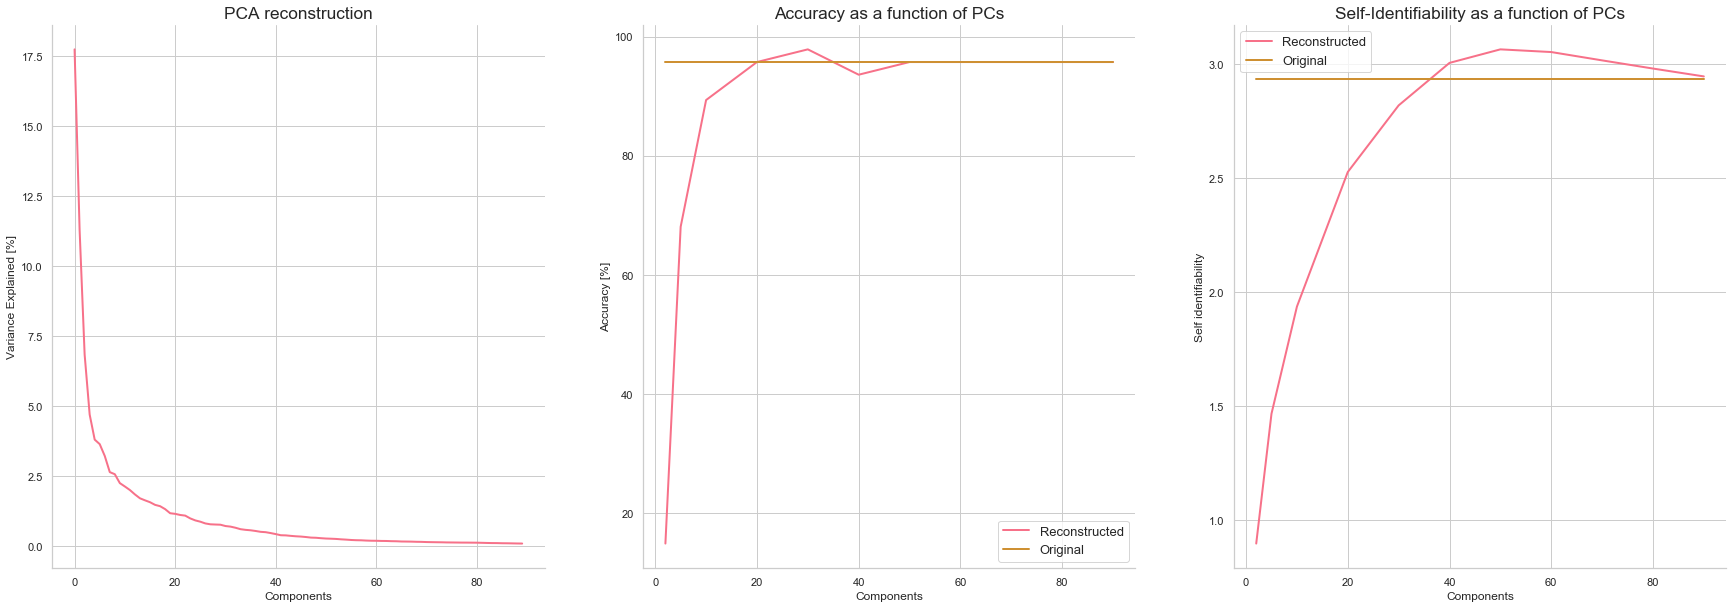

In [6]:
# Get the fig initiated
fig, axs = plt.subplots(1,3, figsize=(30, 10))
fig.subplots_adjust(hspace = .2, wspace = .2)
axs = axs.ravel()

# Variance explained vs Components
axs[0].plot(pca.explained_variance_ratio_*100, linewidth=2)
axs[0].set_xlabel('Components')
axs[0].set_ylabel('Variance Explained [%]')
axs[0].set_title('PCA reconstruction', size = 'x-large')

# Accuracy vs Components
axs[1].plot(steps, pca_target_from_database*100, linewidth = 2, label = 'Reconstructed')
axs[1].plot(steps, target_from_database.repeat(len(steps))*100, linewidth = 2, label = 'Original')
axs[1].set_xlabel('Components')
axs[1].set_ylabel('Accuracy [%]')
axs[1].set_title('Accuracy as a function of PCs', size = 'x-large')
axs[1].legend(fontsize = 13, frameon = True)

# Self identifiability vs Components
axs[2].plot(steps, pca_self_id.mean(axis = 1), linewidth = 2, label = 'Reconstructed')
axs[2].plot(steps, self_id.mean().repeat(len(steps)), linewidth = 2, label = 'Original')
axs[2].set_xlabel('Components')
axs[2].set_ylabel('Self identifiability')
axs[2].set_title('Self-Identifiability as a function of PCs', size = 'x-large')
axs[2].legend(fontsize = 13, frameon = True)

sns.despine()
plt.show()

In [7]:
# Get the PCA reconstruction from the number of components that give us the max self_identifiability 
pca = PCA(n_components = steps[np.argmax(pca_self_id.mean(axis = 1))]) 
pca.fit(fc) # Estimate the components (using an SVD on the centered fc)
fc_pca = pca.transform(fc) # Calculate the loadings
fc_recon = pca.inverse_transform(fc_pca) # Get projection onto components in signal space

# Accuracy and self-identifiability
pca_sub_target = fc_recon[:n_subs, :]
pca_sub_database = fc_recon[n_subs:, :]
pca_z_target = sp.stats.zscore(pca_sub_target, axis = 1)
pca_z_database = sp.stats.zscore(pca_sub_database, axis = 1)
pca_predictions = pca_z_target.dot(pca_z_database.transpose()) / (sub_database.shape[1] - 1) # target, database
pca_target_from_database = accuracy_score(range(n_subs), pca_predictions.argmax(axis = 1))
pca_database_from_target = accuracy_score(range(n_subs), pca_predictions.argmax(axis = 0))
pca_self_id = np.diagonal(sp.stats.zscore(pca_predictions, axis = 1))

print('When predicting the reconstructed target from the reconstructed database, we get a ' + str(pca_target_from_database) + ' accuracy')
print('When predicting the reconstructed database from the reconstructed target, we get a ' + str(pca_database_from_target) + ' accuracy')

When predicting the reconstructed target from the reconstructed database, we get a 0.9574468085106383 accuracy
When predicting the reconstructed database from the reconstructed target, we get a 0.9787234042553191 accuracy


/Users/jasondsc/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


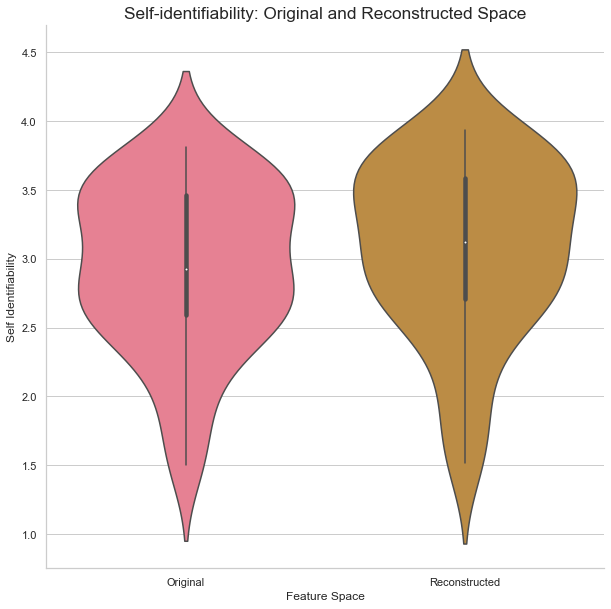

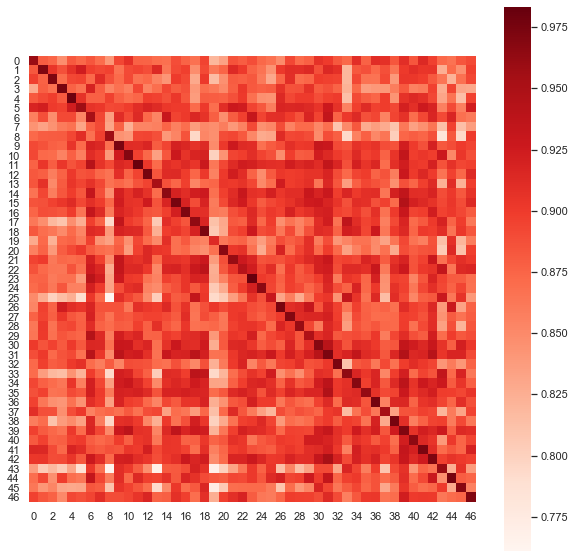

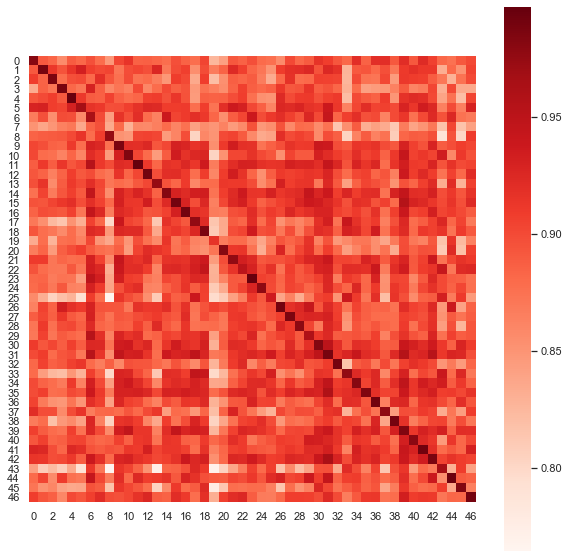

In [8]:
import numpy as np
vp_original = np.concatenate((np.expand_dims(self_id, axis = 1), np.expand_dims(np.repeat('Original', n_subs), axis = 1)), axis = 1)
vp_recon = np.concatenate((np.expand_dims(pca_self_id, axis = 1), np.expand_dims(np.repeat('Reconstructed', n_subs), axis = 1)), axis = 1)
self_id_grand = np.concatenate((vp_original, vp_recon), axis = 0)
self_id_plot = pd.DataFrame(data = self_id_grand, columns = ['Self Identifiability', 'Feature Space'])
self_id_plot['Self Identifiability'] = self_id_plot['Self Identifiability'].astype(float)
self_id_plot['Feature Space'] = self_id_plot['Feature Space'].astype('category', ordered = False, categories = ['Original', 'Reconstructed'])

plt.figure(figsize=(10, 10))
axs = sns.violinplot(x = 'Feature Space', y = 'Self Identifiability', data = self_id_plot)
axs.set_title('Self-identifiability: Original and Reconstructed Space', size = 'x-large')
sns.despine()
plt.show()

plt.figure(figsize=(10, 10))
axs = sns.heatmap(predictions, cmap='Reds', square=True)
plt.figure(figsize=(10, 10))
axs = sns.heatmap(pca_predictions, cmap='Reds', square=True)


# IV. Identifiability as a function of subjects' characteristics

In [9]:
# First we get subject number
def subs_list(sub):
    if sub < 10:
        return 'sub-000' + sub.astype(int).astype(str)
    elif sub >= 10 and sub < 100:
        return 'sub-00' + sub.astype(int).astype(str)
    else: 
        return 'sub-0' + sub.astype(int).astype(str)
    
    
# Get subject data from 
subs_analyzed = list(map(subs_list, sub_target[:, -1]))
subs_omega = pd.read_csv('data/OMEGA_BIDS/participants.csv', sep=',', header=0)
subs_omega = subs_omega[subs_omega['participants_id'].isin(subs_analyzed)]

# Wrangle data to get subjecs' age
sub_age = list(subs_omega['X.session.age.'].values)
for x in range(len(sub_age)):
    if isinstance(sub_age[x], str):
        sub_age[x] = sub_age[x][3:5]
    if (sub_age[x]==""):
        sub_age[x] = np.nan
        
sub_age = np.array(sub_age).astype(float)
age_mean = np.floor(np.nanmean(sub_age))
inds = np.where(np.isnan(sub_age))
sub_age[inds] = age_mean
subs_omega['X.session.age.'] = sub_age
subs_omega = subs_omega.rename(columns={'X.session.age.': 'age'})


# Wrangle data to get subjects' group
sub_group = list(subs_omega['Group'].values)
for x in range(len(sub_group)):
    if isinstance(sub_group[x], str):
        if sub_group[x] != 'Control':
            sub_group[x] = 'Spec'
    else:
        sub_group[x] = 'Control' # The most common label here is 'Control', so I decided to handles NaN's that way
subs_omega['Group'] = sub_group

sub_time= list(subs_omega['time_of_record'].values)
subs_omega['time_of_record']= sub_time

diff_record = pd.read_csv('data/OMEGA_BIDS/scan_times_diff.csv', sep=',', header=0)

subs_omega['difference_between_recordings']=diff_record['diff'].values

# Do some final wrangling before plotting relationshisp between variables and 
subs_omega['identifiability'] = self_id
subs_omega['pca_identifiability'] = pca_self_id
subs_omega = subs_omega.rename(columns={'Dominant.Hand': 'Dominant Hand'})
subs_omega = subs_omega.drop(['Year.of.birth', 'Questionnaire.Version'], axis = 1)


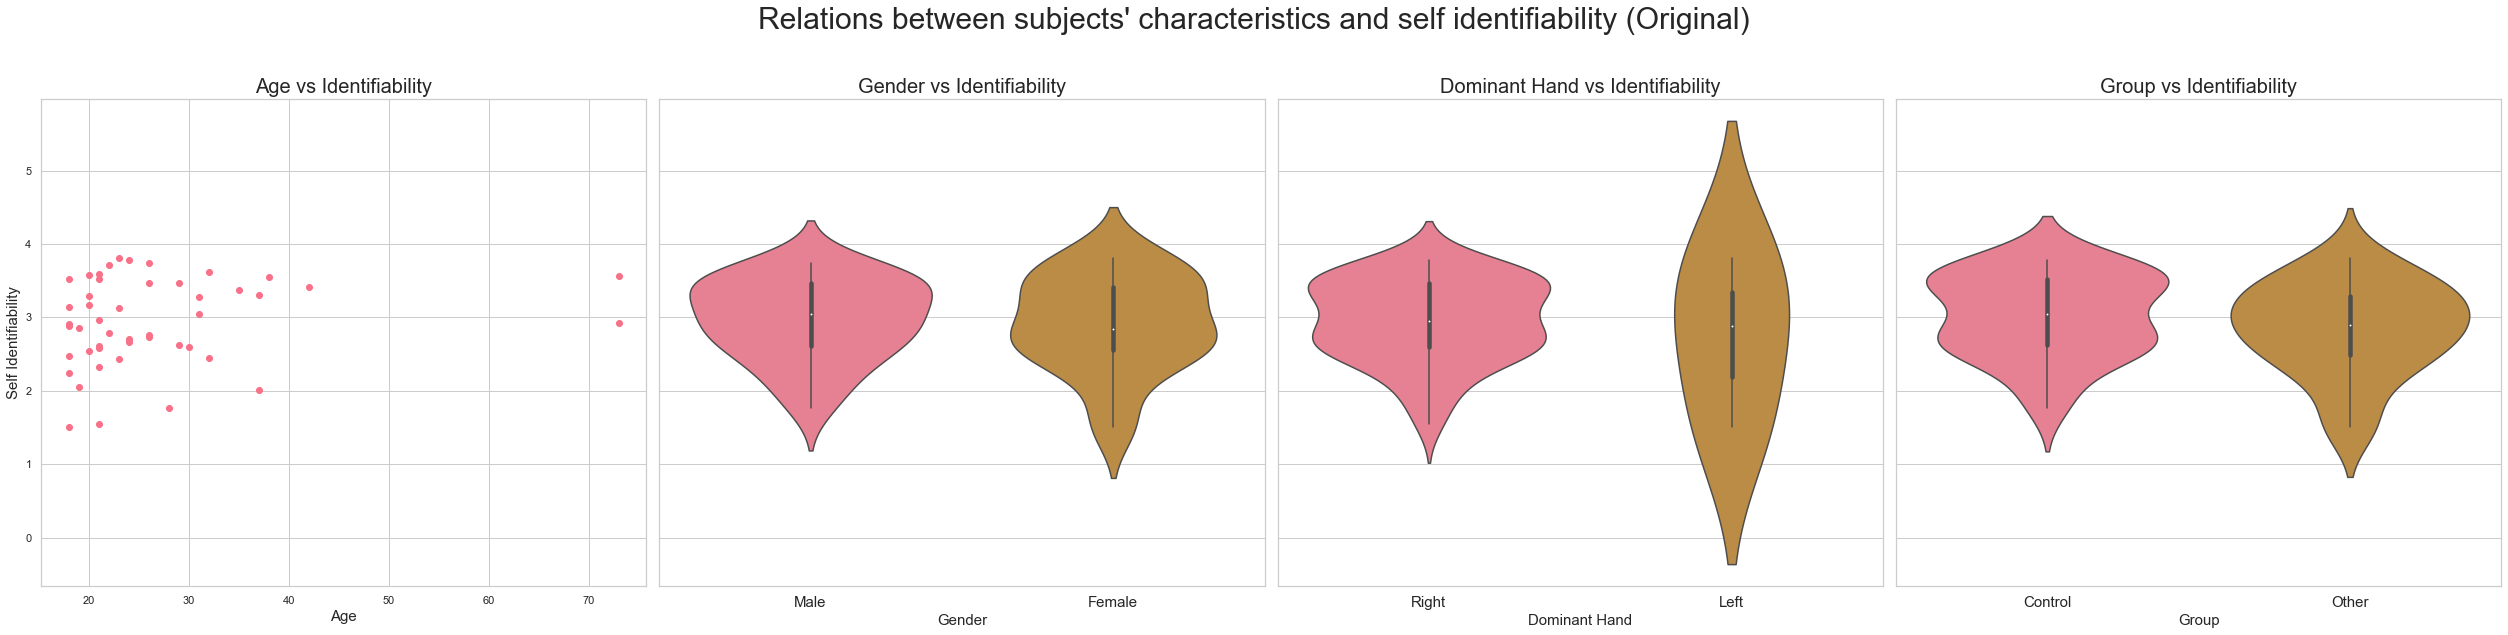

In [10]:
# Plot relations between group, age, gender, dominant hand -and- identifiability
fig, axs = plt.subplots(1,4, figsize=(35, 8), sharey=True)
fig.subplots_adjust(hspace = .2, wspace = .2)
axs = axs.ravel()

# Age
axs[0].scatter(subs_omega['age'].values, subs_omega['identifiability'].values)    
axs[0].set_title('Age vs Identifiability', fontsize = 20)
axs[0].set_xlabel('Age', fontsize = 15)
axs[0].set_ylabel('Self Identifiability', fontsize = 15)

# Gender
sns.violinplot(x = 'Gender', y = 'identifiability', data = subs_omega, ax = axs[1])
axs[1].set_xlabel('Gender', fontsize = 15)
axs[1].set_xticklabels(['Male','Female'], fontsize = 15)
axs[1].set_ylabel('')
axs[1].set_title('Gender vs Identifiability', fontsize = 20)


# Dominant hand
sns.violinplot(x = 'Dominant Hand', y = 'identifiability', data = subs_omega, ax = axs[2])
axs[2].set_ylabel('')
axs[2].set_xlabel('Dominant Hand', fontsize = 15)
axs[2].set_xticklabels(['Right','Left', 'Other'], fontsize = 15)
axs[2].set_title('Dominant Hand vs Identifiability', fontsize = 20)

# Group
sns.violinplot(x = 'Group', y = 'identifiability', data = subs_omega, ax = axs[3])
axs[3].set_ylabel('')
axs[3].set_xlabel('Group', fontsize = 15)
axs[3].set_xticklabels(['Control','Other'], fontsize = 15)
axs[3].set_title('Group vs Identifiability', fontsize = 20)

plt.suptitle('Relations between subjects\' characteristics and self identifiability (Original)', y=1.1, size = 30)
plt.tight_layout()
plt.show()

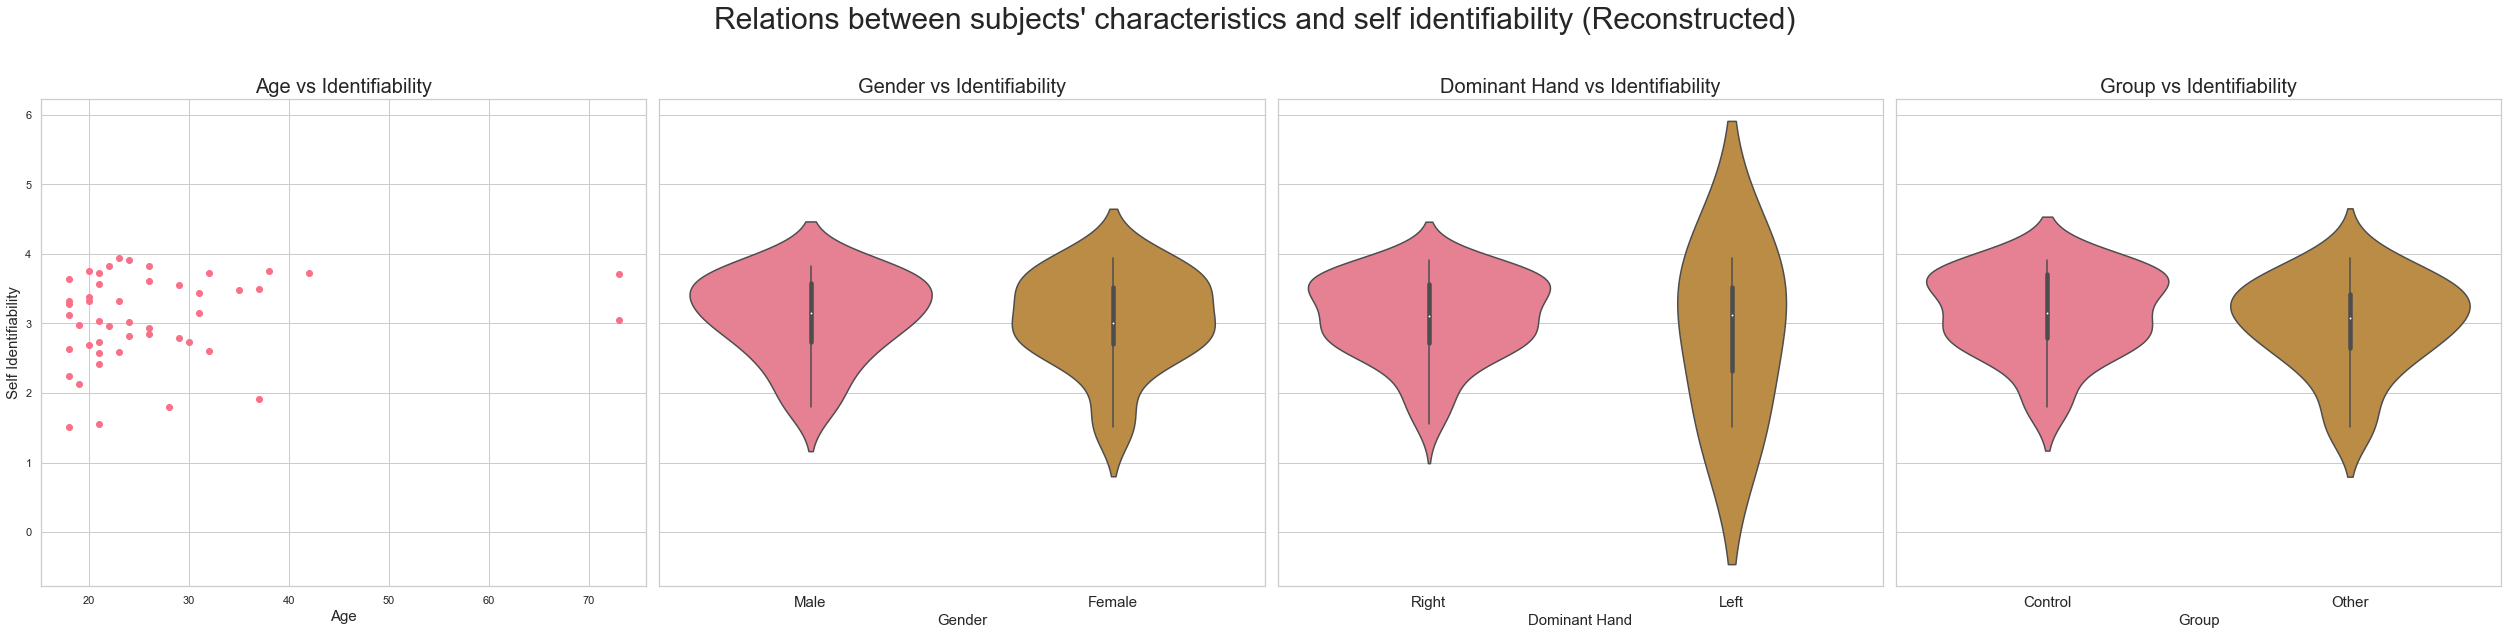

In [11]:
# Plot relations between group, age, gender, dominant hand -and- identifiability
fig, axs = plt.subplots(1,4, figsize=(35, 8), sharey=True)
fig.subplots_adjust(hspace = .2, wspace = .2)
axs = axs.ravel()

# Age
axs[0].scatter(subs_omega['age'].values, subs_omega['pca_identifiability'].values)    
axs[0].set_title('Age vs Identifiability', fontsize = 20)
axs[0].set_xlabel('Age', fontsize = 15)
axs[0].set_ylabel('Self Identifiability', fontsize = 15)

# Gender
sns.violinplot(x = 'Gender', y = 'pca_identifiability', data = subs_omega, ax = axs[1])
axs[1].set_xlabel('Gender', fontsize = 15)
axs[1].set_xticklabels(['Male','Female'], fontsize = 15)
axs[1].set_ylabel('')
axs[1].set_title('Gender vs Identifiability', fontsize = 20)


# Dominant hand
sns.violinplot(x = 'Dominant Hand', y = 'pca_identifiability', data = subs_omega, ax = axs[2])
axs[2].set_ylabel('')
axs[2].set_xlabel('Dominant Hand', fontsize = 15)
axs[2].set_xticklabels(['Right','Left', 'Other'], fontsize = 15)
axs[2].set_title('Dominant Hand vs Identifiability', fontsize = 20)

# Group
sns.violinplot(x = 'Group', y = 'pca_identifiability', data = subs_omega, ax = axs[3])
axs[3].set_ylabel('')
axs[3].set_xlabel('Group', fontsize = 15)
axs[3].set_xticklabels(['Control','Other'], fontsize = 15)
axs[3].set_title('Group vs Identifiability', fontsize = 20)

plt.suptitle('Relations between subjects\' characteristics and self identifiability (Reconstructed)', y=1.1, size = 30)
plt.tight_layout()
plt.show()

# V. Sanity checks: Identifiability as a function of summary statistics for motion, cardiac activity, and eye movements

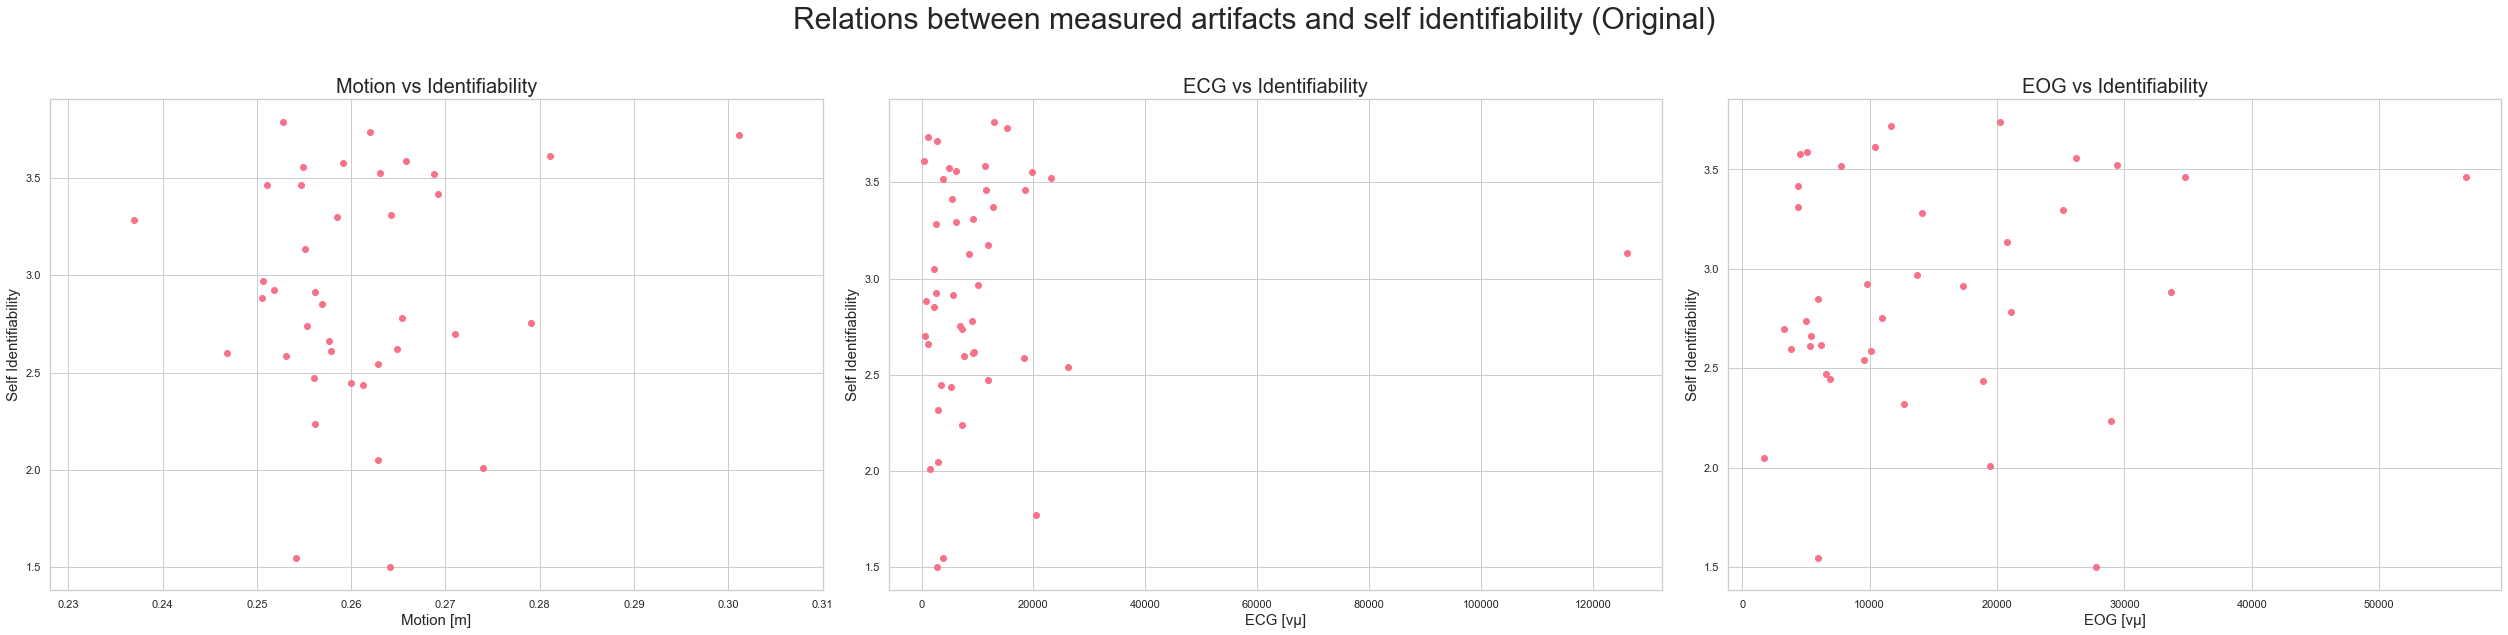

In [12]:
# First we get a big data frame
sanity_check = pd.read_csv('dependencies/eog_ecg_motion.csv')
sanity_check = sanity_check.head(n_subs)
sanity_check['self_id'] = self_id
sanity_check['pca_self_id'] = pca_self_id

# Plot relations between motion, ecg, eog -and- identifiability
fig, axs = plt.subplots(1,3, figsize=(35, 8))
fig.subplots_adjust(hspace = .2, wspace = .2)
axs = axs.ravel()

# Motion
axs[0].scatter(sanity_check['motion'].values, sanity_check['self_id'].values)    
axs[0].set_title('Motion vs Identifiability', fontsize = 20)
axs[0].set_xlabel('Motion [m]', fontsize = 15)
axs[0].set_ylabel('Self Identifiability', fontsize = 15)

# ECG
axs[1].scatter(sanity_check['ecg'].values, sanity_check['self_id'].values)    
axs[1].set_title('ECG vs Identifiability', fontsize = 20)
axs[1].set_xlabel('ECG [vµ]', fontsize = 15)
axs[1].set_ylabel('Self Identifiability', fontsize = 15)

# EOG
axs[2].scatter(sanity_check['eog'].values, sanity_check['self_id'].values)    
axs[2].set_title('EOG vs Identifiability', fontsize = 20)
axs[2].set_xlabel('EOG [vµ]', fontsize = 15)
axs[2].set_ylabel('Self Identifiability', fontsize = 15)

plt.suptitle('Relations between measured artifacts and self identifiability (Original)', y=1.1, size = 30)
plt.tight_layout()
plt.show()

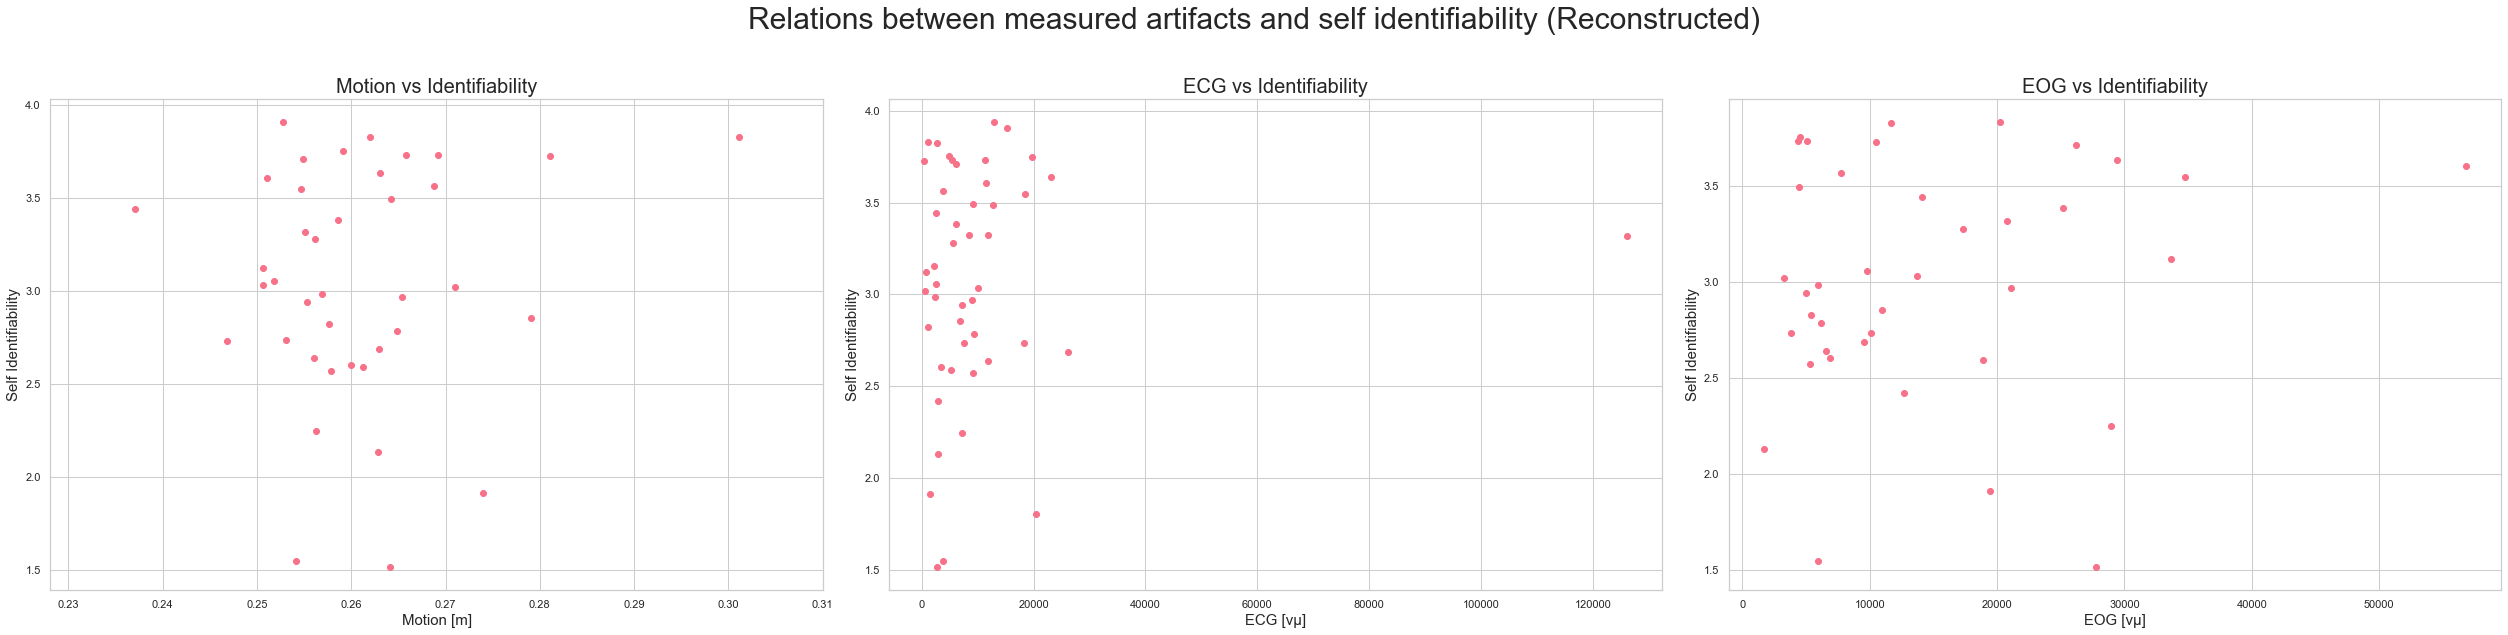

In [13]:
# Plot relations between motion, ecg, eog -and- identifiability
fig, axs = plt.subplots(1,3, figsize=(35, 8))
fig.subplots_adjust(hspace = .2, wspace = .2)
axs = axs.ravel()

# Motion
axs[0].scatter(sanity_check['motion'].values, sanity_check['pca_self_id'].values)    
axs[0].set_title('Motion vs Identifiability', fontsize = 20)
axs[0].set_xlabel('Motion [m]', fontsize = 15)
axs[0].set_ylabel('Self Identifiability', fontsize = 15)

# ECG
axs[1].scatter(sanity_check['ecg'].values, sanity_check['pca_self_id'].values)    
axs[1].set_title('ECG vs Identifiability', fontsize = 20)
axs[1].set_xlabel('ECG [vµ]', fontsize = 15)
axs[1].set_ylabel('Self Identifiability', fontsize = 15)

# EOG
axs[2].scatter(sanity_check['eog'].values, sanity_check['pca_self_id'].values)    
axs[2].set_title('EOG vs Identifiability', fontsize = 20)
axs[2].set_xlabel('EOG [vµ]', fontsize = 15)
axs[2].set_ylabel('Self Identifiability', fontsize = 15)

plt.suptitle('Relations between measured artifacts and self identifiability (Reconstructed)', y=1.1, size = 30)
plt.tight_layout()
plt.show()

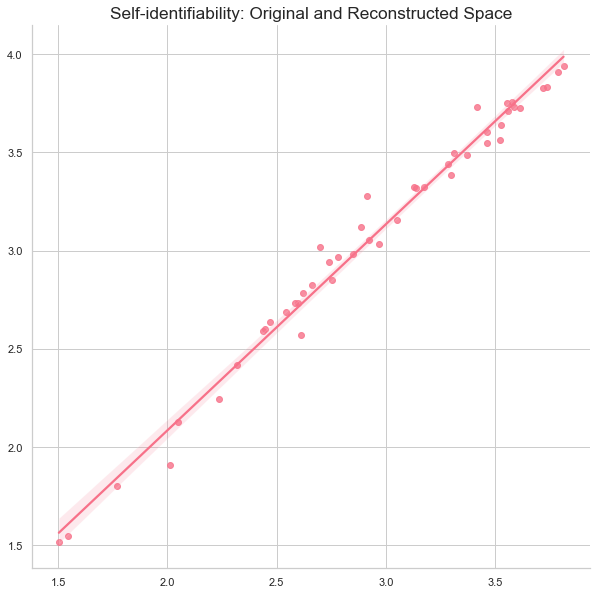

In [14]:
plt.figure(figsize=(10, 10))
axs = sns.regplot(subs_omega['identifiability'].values, subs_omega['pca_identifiability'].values)
axs.set_title('Self-identifiability: Original and Reconstructed Space', size = 'x-large')
sns.despine()
plt.show()

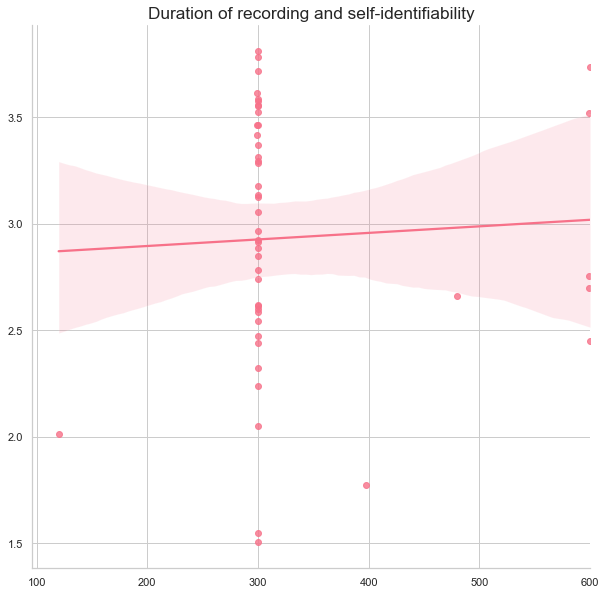

In [15]:
# Plot rduration of recording identifiability
plt.figure(figsize=(10, 10))
axs = sns.regplot(subs_omega['time_of_record'].values, subs_omega['identifiability'].values)
axs.set_title('Duration of recording and self-identifiability', size = 'x-large')
sns.despine()
plt.show()